# 1. Introduction and Dataset Overview


**Dataset Name**: Real or Fake Job Posting Prediction

**Source**: Kaggle (https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction/data)

**Purpose**: To predict whether a job posting is real or fake.

**Problem Type**: Binary Classification

**Target Variable**: fraudulent (1: Fake, 0: Real)

**Key Features**: 

* **title:** Name of the beach.
* **location:** Name of the beach.
* **description:** Name of the beach.
* **requirements:** Name of the beach.
* **benefits:** Name of the beach.
* **telecommuting:** Name of the beach.
* **has_company_logo:** Name of the beach.
* **has_questions:** Name of the beach.
* **employment_type:** Name of the beach.
* **required_experience:** Name of the beach.
* **required_education:** Name of the beach.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from nltk.corpus import stopwords
import string
import nltk
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder

In [2]:
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

## 1.1 Loading the dataset

In [3]:
try:
    df = pd.read_csv("data/fake_job_postings.csv")  # Load from local file
except FileNotFoundError:
    # If the file is not found locally, attempt to load it from the Kaggle URL. 
    print("Error: 'fake_job_postings.csv' not found. Please download it from Kaggle and place it in the same directory as this script.")
    df = None # set df to None to prevent further errors
    exit()

## 1.2 Checking for target class distribution 

In [4]:
# Check for balanced or imbalanced class distribution
print("\nClass Distribution:")
print(df['fraudulent'].value_counts())
print(f"\nProportion of Fake Postings: {df['fraudulent'].mean():.4f}")


Class Distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64

Proportion of Fake Postings: 0.0484


# 2. Data Preprocessing and Cleaning

In [5]:
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

## 2.1 Dropping unwanted columns

In [7]:
unwanted_columns = ['job_id','location','salary_range', 'department'] 
df = df.drop(columns=unwanted_columns, errors='ignore')
print("\nAfter Dropping Unwanted Columns:")
df.head()


After Dropping Unwanted Columns:


,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 2.2 Handling Missing Data

In [8]:
print("\nMissing Data Before Handling:")
df.isnull().sum()


Missing Data Before Handling:


title                     0
company_profile        3308
description               1
requirements           2696
benefits               7212
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64

In [9]:
# Impute missing text data with "Missing"
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('Missing')

In [10]:
# Impute categorical features with the mode
categorical_columns = ['employment_type', 'required_education', 'required_experience', 'function', 'industry']
for col in categorical_columns:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

In [11]:
# Impute numerical features with the median
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('fraudulent') 
if numerical_cols: 
    imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [12]:
print("\nMissing Data After Handling:")
print(df.isnull().sum())


Missing Data After Handling:
title                  0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64


## 2.3 Handling Outliers

In [14]:
numerical_cols

['telecommuting', 'has_company_logo', 'has_questions']

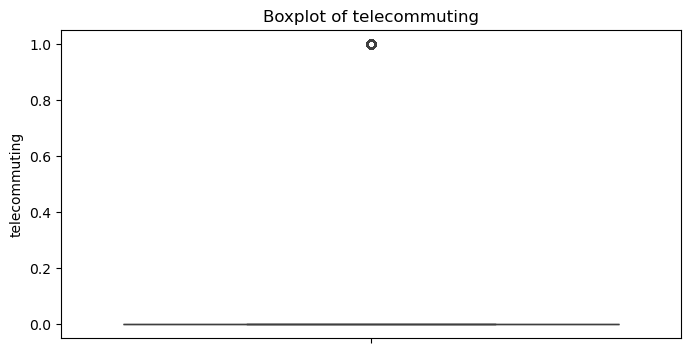

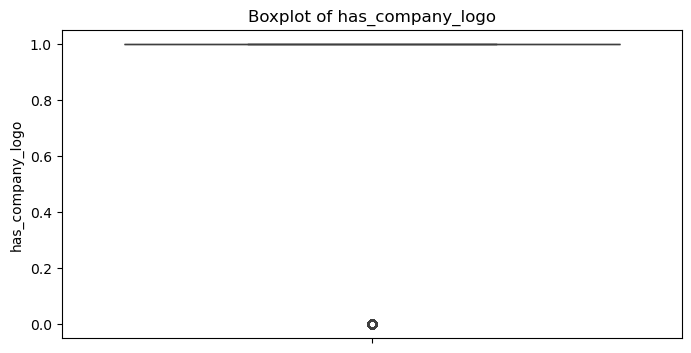

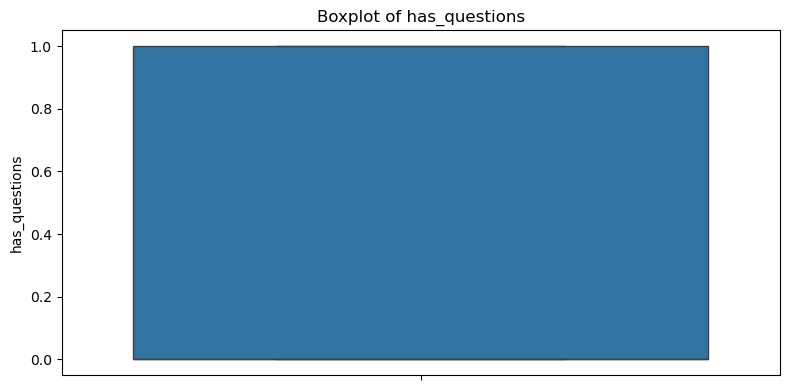

In [15]:
for i, col in enumerate(numerical_cols):
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [16]:
df_no_target = df[numerical_cols]
z_scores = zscore(df_no_target)
abs_z_scores = np.abs(z_scores)
filtering_mask = (abs_z_scores < 3).all(axis=1) 
print(f"Shape after outlier removal: {df.shape}")


Shape after outlier removal: (17880, 14)


In [17]:
for col in categorical_columns:
    print(f"{df[col].value_counts()}\n")

employment_type
Full-time    15091
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64

required_education
Bachelor's Degree                    13250
High School or equivalent             2080
Unspecified                           1397
Master's Degree                        416
Associate Degree                       274
Certification                          170
Some College Coursework Completed      102
Professional                            74
Vocational                              49
Some High School Coursework             27
Doctorate                               26
Vocational - HS Diploma                  9
Vocational - Degree                      6
Name: count, dtype: int64

required_experience
Mid-Senior level    10859
Entry level          2697
Associate            2297
Not Applicable       1116
Director              389
Internship            381
Executive             141
Name: count, dtype: int64

function
Information Technol

# 3. Exploratory Data Analysis (EDA)

## 3.1 Descriptive Statistics

In [18]:
numerical_desc = df.describe()
numerical_desc

,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434
std,0.202631,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [19]:
categorical_desc = df.describe(exclude=np.number)
categorical_desc

,title,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function
count,17880,17880,17880,17880,17880,17880,17880,17880,17880,17880
unique,11231,1710,14802,11966,6204,5,7,13,131,37
top,English Teacher Abroad,Missing,"Play with kids, get paid for it Love travel? J...",Missing,Missing,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology
freq,311,3308,379,2696,7212,15091,10859,13250,6637,8204


## 3.2 Correlation Analysis

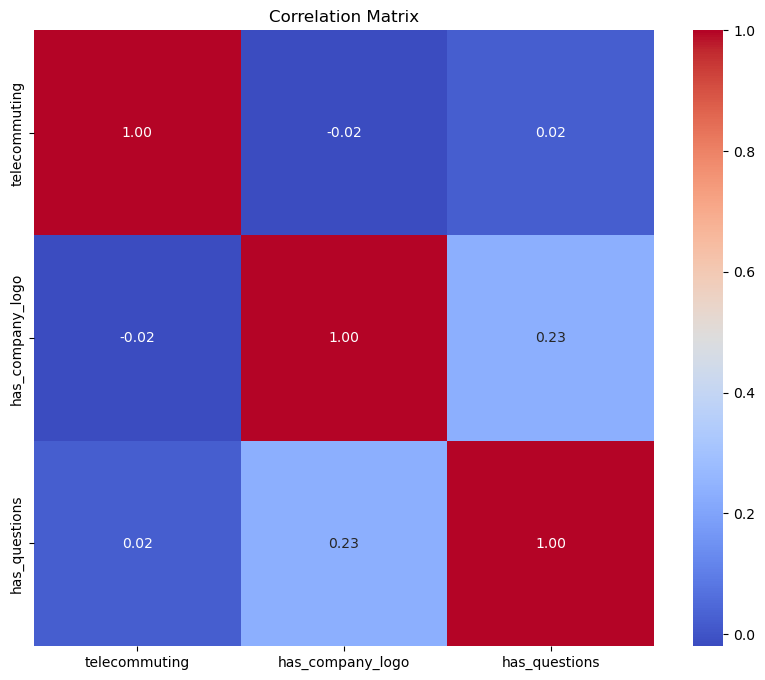

In [20]:
# Calculate correlation matrix
cor_matrix = df[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 3.3 Visualizations

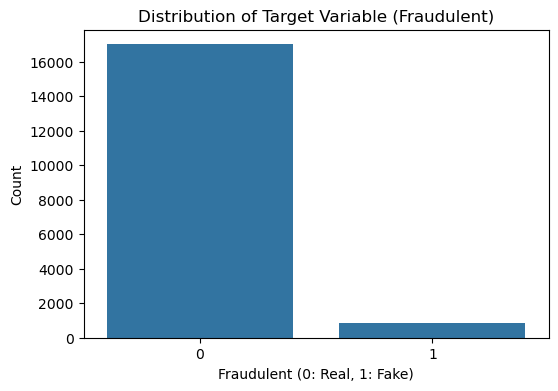

In [21]:
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Target Variable (Fraudulent)')
plt.xlabel('Fraudulent (0: Real, 1: Fake)')
plt.ylabel('Count')
plt.show()

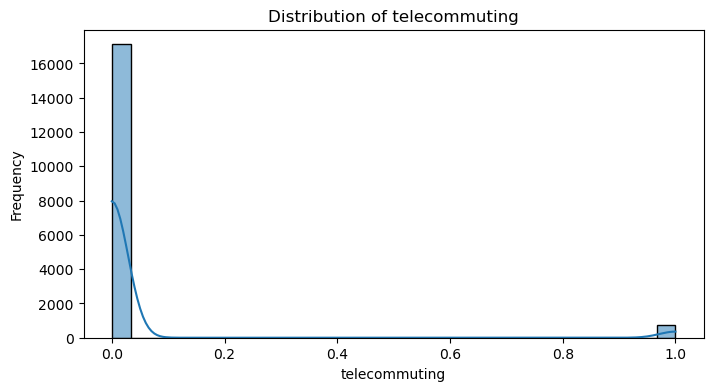

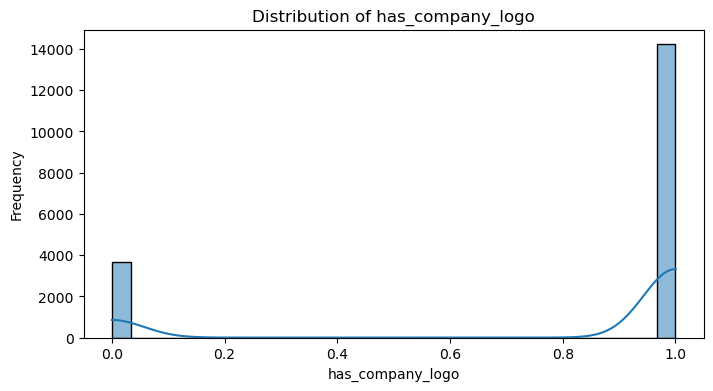

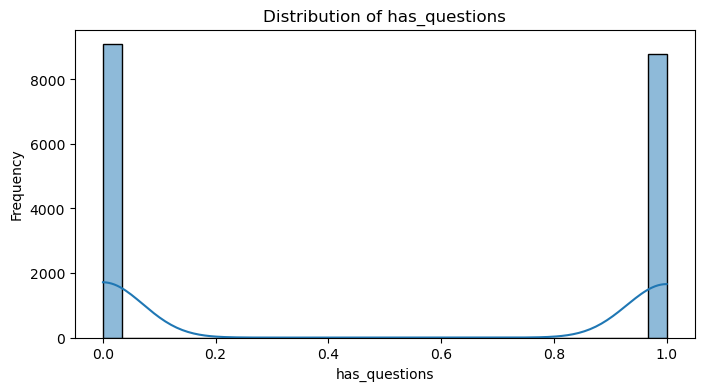

In [22]:
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

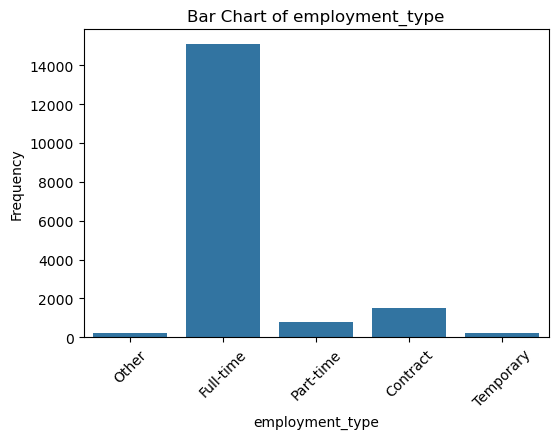

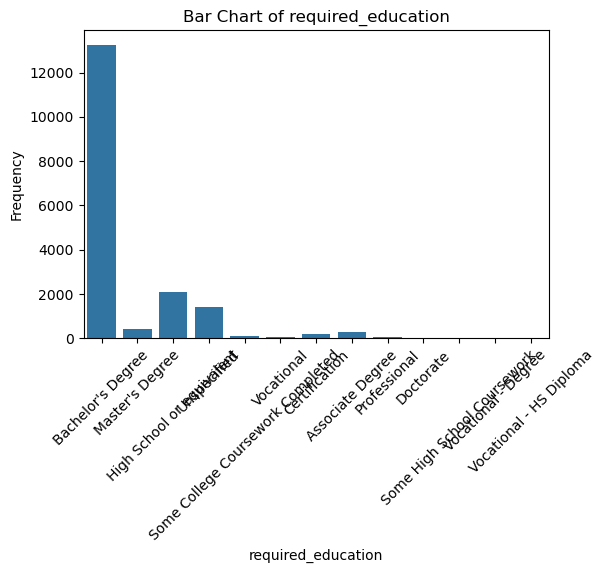

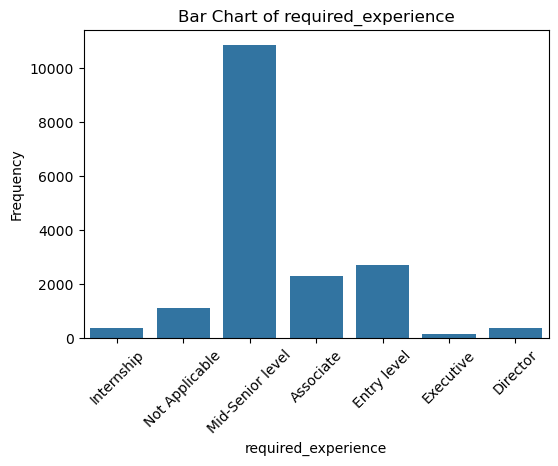

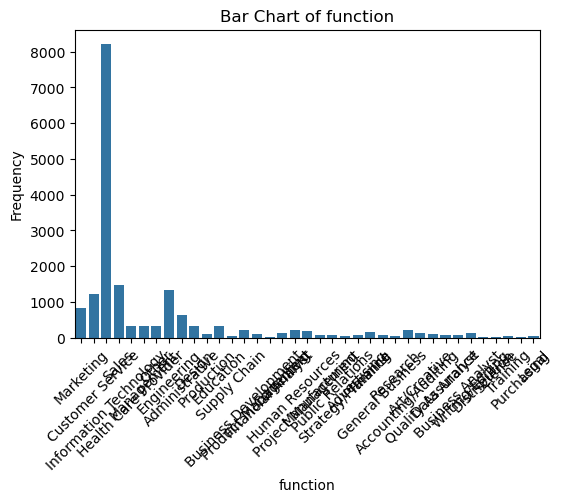

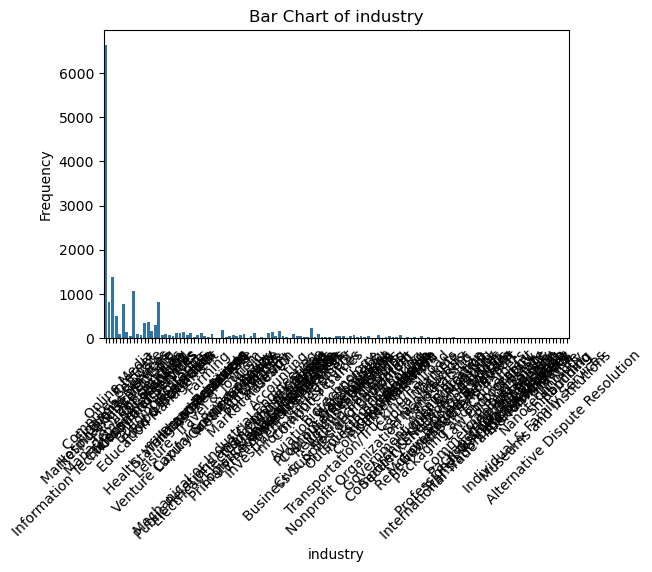

In [23]:
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[col])
    plt.title(f'Bar Chart of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# 4. Feature Engineering & Transformation

## 4.1 Encoding Categorical columns

In [24]:
for col in categorical_columns:
    if col == "employment_type":
        one_hot_encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
        X_encoded = one_hot_encoder.fit_transform(df[[col]])
        df= df.drop(columns=[col])
        df = pd.concat([df, pd.DataFrame(X_encoded.toarray(), index=df.index,columns=one_hot_encoder.get_feature_names_out())], axis=1)

    elif col in ["required_experience", "required_education"]:
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
    
    elif col in ["function", "industry"]:
        target_encoder = TargetEncoder()
        df[col] = target_encoder.fit_transform(df[col],df['fraudulent'])

## 4.2 TF_IDF Vectoristaion

In [25]:
def clean_text(text):
    """
    Cleans the input text by removing punctuation, converting to lowercase,
    and removing stop words.

    Args:
        text (str): The text to be cleaned.

    Returns:
        str: The cleaned text.
    """
    if isinstance(text, str):  # Check if the input is a string
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [w for w in tokens if not w in stop_words]
        return " ".join(tokens)
    else:
        return "" # Return empty string for non-string input

In [26]:
for col in text_columns:
    df[col] = df[col].apply(clean_text)

In [27]:
df['combined_text'] = df[text_columns].apply(lambda row: ' '.join(row.values), axis=1)

In [28]:
# Vectorize the combined text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [29]:
# Concatenate TF-IDF features with the original dataframe
df = pd.concat([df, tfidf_df], axis=1)

In [ ]:
# Drop the original text columns and the combined text column
df = df.drop(columns=text_columns + ['combined_text'])

In [ ]:
print("\nData After Text Vectorization:")
df.head()


Data After Text Vectorization:


,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Missing,0.0,1.0,0.0,Other,Internship,Bachelor's Degree,Information Technology and Services,Marketing,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0.0,1.0,0.0,Full-time,Not Applicable,Bachelor's Degree,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Missing,0.0,1.0,0.0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0.0,1.0,0.0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0.0,1.0,1.0,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# 5. Model Selection and Training

In [32]:
X = df.select_dtypes(exclude=['int64'])
y = df['fraudulent'].select_dtypes(include=['int']).values.ravel()


In [33]:
X.head()

,telecommuting,has_company_logo,has_questions,required_experience,required_education,industry,function,employment_type_Full-time,employment_type_Other,employment_type_Part-time,...,τις,το,τον,του,τους,των,χώρο,όπως,ότι,оптовых
0,0.0,1.0,0.0,4,1,0.046256,0.012048,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,6,1,0.054348,0.054516,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,5,1,0.046256,0.044978,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,5,1,0.003634,0.027929,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,5,1,0.102616,0.002959,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [35]:
# Split the dataset into training, validation, and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) # 80% train-validation set , 20% test set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.375, stratify=y_temp, random_state=42)  #50% train set, 30 % validation set


In [36]:
# K-fold cross-validation (Stratified)
def perform_cross_validation(model, X, y, cv=5):
    """
    Performs stratified k-fold cross-validation and returns the mean and standard deviation
    of the F1-score.

    Args:
        model: The machine learning model to evaluate.
        X (pd.DataFrame): The feature matrix.
        y (pd.Series): The target variable.
        cv (int): The number of folds for cross-validation.  Defaults to 5.

    Returns:
        tuple: (mean_f1, std_f1) - The mean and standard deviation of the F1-score.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42) # Use StratifiedKFold
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')
    return np.mean(f1_scores), np.std(f1_scores)

## LogisticRegression

In [37]:
logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') # Add class_weight

In [38]:
print("\nCross-Validation Results:")
lr_mean_f1, lr_std_f1 = perform_cross_validation(logistic_regression_model, X_train, y_train)
print(f"Logistic Regression: Mean F1-score = {lr_mean_f1:.4f}, Std F1-score = {lr_std_f1:.4f}")


Cross-Validation Results:
Logistic Regression: Mean F1-score = 0.6476, Std F1-score = 0.0168


In [39]:
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

## RandomForest

In [40]:
random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced') # Add class_weight

In [41]:
print("\nCross-Validation Results:")
rf_mean_f1, rf_std_f1 = perform_cross_validation(random_forest_model, X_train, y_train)
print(f"Random Forest: Mean F1-score = {rf_mean_f1:.4f}, Std F1-score = {rf_std_f1:.4f}")


Cross-Validation Results:
Random Forest: Mean F1-score = 0.6400, Std F1-score = 0.0634


In [42]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

# 5. Model Performance Evaluation

In [43]:
def evaluate_model(model, X, y, model_name="Model"):
    """
    Evaluates the performance of a given model and prints various metrics.
    Also generates and displays the confusion matrix and ROC curve.

    Args:
        model: The trained machine learning model.
        X (pd.DataFrame): The feature matrix.
        y (pd.Series): The target variable.
        model_name (str): Name of the model
    """
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)

    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y, y_pred), display_labels=[0, 1])
    confusion_matrix_display.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y, y_pred_proba)
    average_precision = average_precision_score(y, y_pred_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(recall_curve, precision_curve, color='b',label=f'{model_name} (AP = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
    return y_pred, y_pred_proba #returning the predictions.


Logistic Regression Performance:
Accuracy: 0.9653
Precision: 0.5968
Recall: 0.8728
F1-score: 0.7089
ROC-AUC: 0.9824


<Figure size 600x500 with 0 Axes>

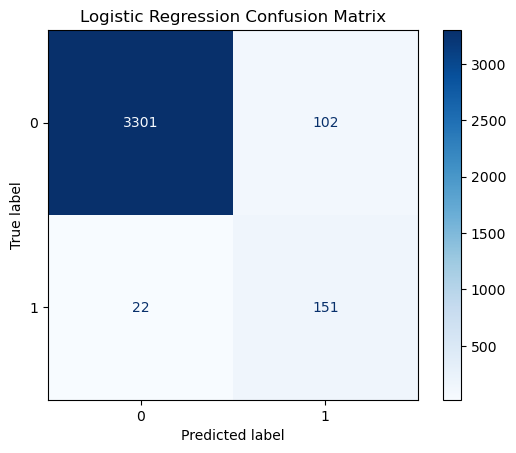

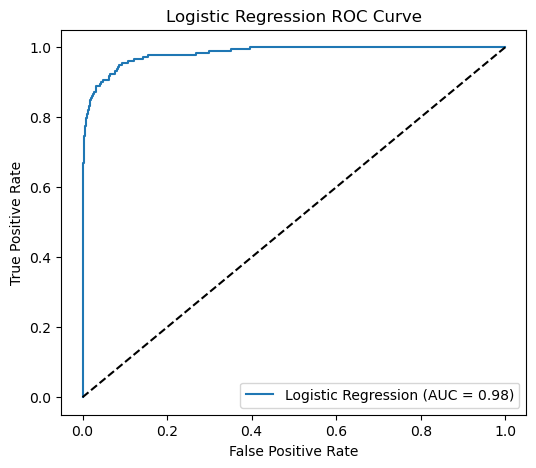

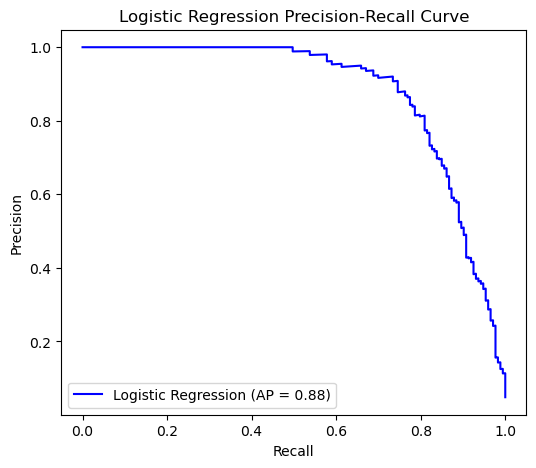

In [44]:
# Evaluate Logistic Regression
y_pred_lr, y_pred_proba_lr = evaluate_model(logistic_regression_model, X_test, y_test, "Logistic Regression")


Random Forest Performance:
Accuracy: 0.9743
Precision: 0.9880
Recall: 0.4740
F1-score: 0.6406
ROC-AUC: 0.9860


<Figure size 600x500 with 0 Axes>

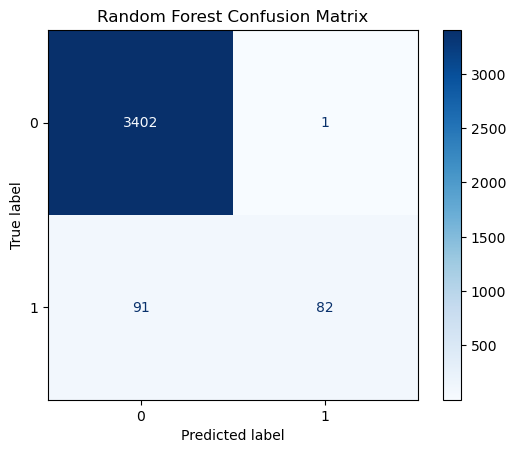

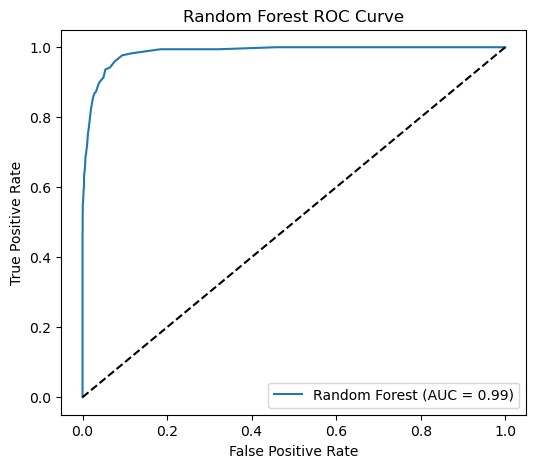

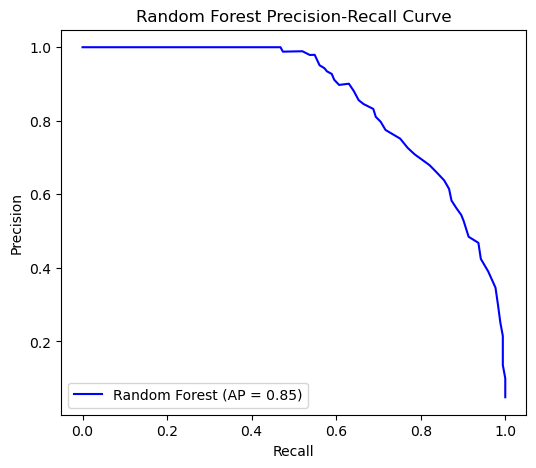

In [45]:
# Evaluate Random Forest
y_pred_rf, y_pred_proba_rf = evaluate_model(random_forest_model, X_test, y_test, "Random Forest")

# 6. Compare Model Results

In [46]:
# Compare overall performance (Accuracy, F1, AUC)
results = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'],
    'Logistic Regression': [
        accuracy_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_proba_lr)
    ],
    'Random Forest': [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf),
        roc_auc_score(y_test, y_pred_proba_rf)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

      Metric  Logistic Regression  Random Forest
0   Accuracy             0.965324       0.974273
1  Precision             0.596838       0.987952
2     Recall             0.872832       0.473988
3   F1-score             0.708920       0.640625
4    ROC-AUC             0.982443       0.986014
